In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.aggregation.settings import Config
from src.aggregation.utils import Network, Results, FineNetwork, CoarseNetwork, haversine_matrix
from src.aggregation.models import SpatialAggregation, TemporalAggregation
from src.aggregation.pipeline import StaticPreprocessor, DynamicProcessor
from src.gtep.pipeline import run_aggregated, run_spatial, run_temporal, consume, run_experiment
from src.gtep.types import RunArtifacts
from src.gtep.utils import ensure_unique

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB
import json
from dataclasses import asdict
import hashlib
import seaborn as sns

def load_aggregation_pickle(path):
    pathlib.PosixPath = pathlib.WindowsPath
    with open(path, "rb") as f:
        return pickle.load(f)


In [ ]:
EXP_DIR = PROJECT_ROOT / "experiments" / "exp02_pareto"
manifest_path = EXP_DIR / "manifest_pareto_P4.csv"
manifest_df = pd.read_csv(manifest_path)

In [ ]:
df = manifest_df[manifest_df["stage"] == "temporal"].copy()
df[["C", "D"]] = df["id"].str.extract(r"r25_n(?P<N>\d+)_k(?P<K>\d+)").astype(int)
pareto_df = df[["objective","C","D"]]
print(pareto_df)

In [ ]:
import pandas as pd
import numpy as np

# All objectives (objective, C, D) are to be minimized
def is_dominated(p, others):
    return np.any(
        np.all(others <= p, axis=1) & np.any(others < p, axis=1)
    )

def compute_pareto_frontier(df):
    values = df[["objective", "C", "D"]].values
    pareto_mask = []

    for i, row in enumerate(values):
        others = np.delete(values, i, axis=0)
        dominated = is_dominated(row, others)
        pareto_mask.append(not dominated)

    return df[pareto_mask].copy()

pareto_front = compute_pareto_frontier(pareto_df)
pareto_front

,objective,C,D
11,33909.404139,3,3
20,15737.089047,3,7
71,10476.220129,8,30
77,11382.872733,3,20
98,10613.296734,15,25
101,10286.731964,15,30
116,11320.694285,3,25
119,10905.486766,3,30


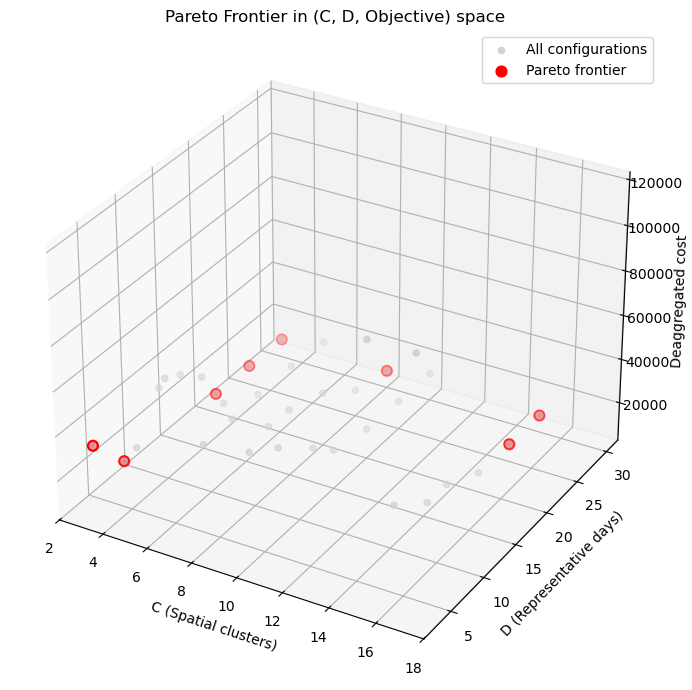

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# All points
ax.scatter(pareto_df["C"], pareto_df["D"], pareto_df["objective"], c='lightgray', label="All configurations")

# Pareto frontier
ax.scatter(pareto_front["C"], pareto_front["D"], pareto_front["objective"], c='red', label="Pareto frontier", s=60)

ax.set_xlabel("C (Spatial clusters)")
ax.set_ylabel("D (Representative days)")
ax.set_zlabel("Deaggregated cost")
ax.set_title("Pareto Frontier in (C, D, Objective) space")
ax.legend()
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figs' / 'pareto_3d.png', dpi=300, bbox_inches='tight')
plt.show()


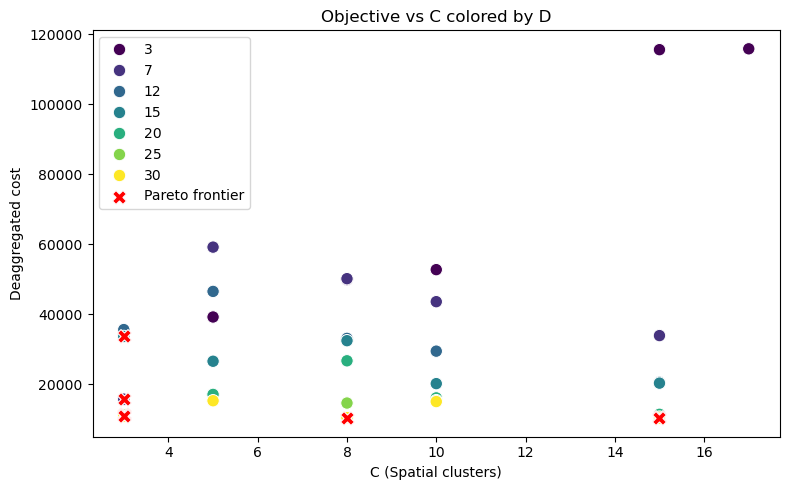

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pareto_df, x="C", y="objective", hue="D", palette="viridis", s=80, legend="full")
sns.scatterplot(data=pareto_front, x="C", y="objective", color="red", label="Pareto frontier", s=100, marker="X")
plt.title("Objective vs C colored by D")
plt.xlabel("C (Spatial clusters)")
plt.ylabel("Deaggregated cost")
plt.legend()
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figs' / 'pareto_C.png', dpi=300, bbox_inches='tight')
plt.show()


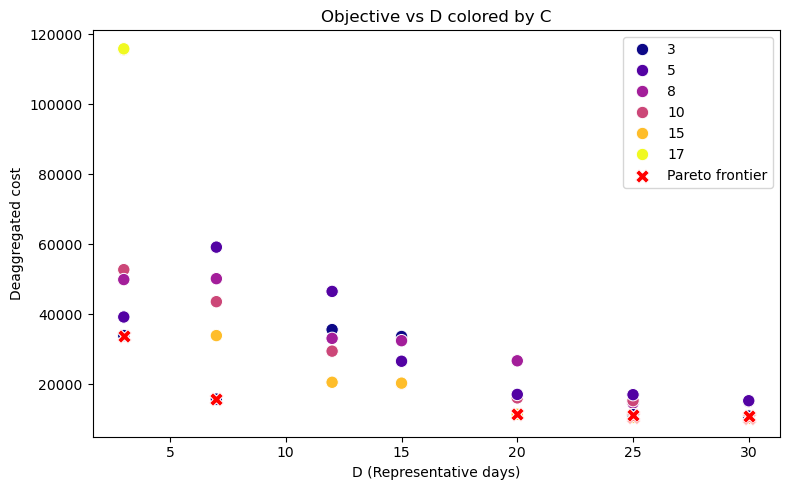

In [13]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pareto_df, x="D", y="objective", hue="C", palette="plasma", s=80, legend="full")
sns.scatterplot(data=pareto_front, x="D", y="objective", color="red", label="Pareto frontier", s=100, marker="X")
plt.title("Objective vs D colored by C")
plt.xlabel("D (Representative days)")
plt.ylabel("Deaggregated cost")
plt.legend()
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figs' / 'pareto_D.png', dpi=300, bbox_inches='tight')
plt.show()
